# NNConv

## Plan :-
- **Add the btag label(0:Not btagged, 1:btagged) to each node feature.**
- **Calculate the R between isophoton and 2 jets and based set the maximum of those as threshold and then form the edges based on it.**

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv
from tqdm import tqdm
import torch.optim as optim
import json
import pprint 

In [2]:
from helper_function_module import init_setup
seed = 876
BATCH_SIZE = 70
device = init_setup(batch_size = BATCH_SIZE, 
           use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.5.1+cu121
- CUDA Version: 12.1
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


# Importing the Main tabular data

In [3]:
with open('./jsonData/ax15_signal_btag_label.json', 'r') as file:
    signal = json.load(file)

with open('../13j3p/json_data/background_btag_label.json', 'r') as file:
    background = json.load(file)

In [4]:
pp = pprint.PrettyPrinter(indent=1)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 119675
Example:
{'edge_index': [[0, 0, 1], [1, 2, 2]],
 'edges': [4.304229448718591, 3.158689293025194, 1.2440566842330778],
 'event_label': 1,
 'eventno': 19443,
 'inv_mass': 268.97487077637555,
 'jet_btag_label': [1.0, 0.0, 0.0],
 'jetmultiplicity': 3,
 'node_labels': [1, 1, 1],
 'nodes': [[1.54684, 2.36506, 51.0003, 125.194],
           [-1.42892, -0.808263, 49.0568, 108.262],
           [-0.825664, 0.279744, 27.0041, 36.7436]]}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Background Event: 126444
Example:
{'edge_index': [],
 'edges': [],
 'event_label': 0,
 'eventno': 199216,
 'inv_mass': 0.1403604645206165,
 'jet_btag_label': [1.0],
 'jetmultiplicity': 2,
 'node_labels': [1],
 'nodes': [[-2.28169, -1.13705, 25.2673, 125.014]]}


In [5]:
signal[3]

{'eventno': 3,
 'nodes': [[2.21481, -1.90697, 23.6507, 109.608]],
 'edges': [],
 'edge_index': [],
 'node_labels': [1],
 'jet_btag_label': [0.0],
 'jetmultiplicity': 1,
 'inv_mass': 0.09452358223803185,
 'event_label': 1}

# Converting Each Event into a PyG Graph Object

In [6]:
import torch
import numpy as np
from torch_geometric.data import Data
from tqdm import tqdm
from helper_function_module import Euclidean_distance as delta_r

def convert_to_pyg_graph(graph, normalize_features=False):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object using a KNN strategy.
    Fully connect one isolated photon and the first two b-tagged jets, then use their distance
    as a threshold to connect other nodes.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'eventno', 'nodes', 'edges', and 'edge_index', 'jet_multiplicity',
        'inv_mass', 'node_labels', 'jet_btag_label', 'event_label' for a single event.
    normalize_features : bool
        Whether to normalize node features.

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features and labels
    event_num = torch.tensor(graph['eventno'], dtype=torch.long)
    node_features = torch.tensor(graph['nodes'], dtype=torch.float)
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.float).view(-1, 1)
    jet_btag_labels = torch.tensor(graph['jet_btag_label'], dtype=torch.float).view(-1, 1)

    # Combine node features with b-tag and node labels
    node_features_with_btag_nodeLabels = torch.cat((node_features[:, :2],jet_btag_labels, node_labels), dim = 1)

    # Find isolated photon and b-tagged jets
    num_nodes = node_features.size(0)
    photon_idx = (node_labels == 0).nonzero(as_tuple=True)[0]  # Index of isolated photon
    btag_indices = (jet_btag_labels == 1).nonzero(as_tuple=True)[0]  # Indices of b-tagged jets
    btag_indices = btag_indices[:2]  # Take first two b-tagged jets

    # Initialize edge_index and edge_attr
    edge_index = []
    edge_attr = []
    threshold = None #deltaR_jet1_jet2
    # Step 1: Fully connect isolated photon and first two b-tagged jets
    if len(photon_idx) > 0 and len(btag_indices) >= 2:
        photon_idx = photon_idx[0]  # Take the first photon if multiple
        jet1_idx, jet2_idx = btag_indices[0], btag_indices[1]

        # Edges involving photon
        dr_photon_jet1 = delta_r(node_features[photon_idx,0:2].numpy(), node_features[jet1_idx,0:2].numpy())
        
        
        dr_photon_jet2 = delta_r(node_features[photon_idx,0:2].numpy(), node_features[jet2_idx,0:2].numpy())

        # Edges involving btagged jets
        dr_jet1_jet2 = delta_r(node_features[jet1_idx,0:2].numpy(), node_features[jet2_idx,0:2].numpy())
               
        # Threshold based on minimum distance among the isophoton and the two b-tagged jets
        threshold = np.max([dr_photon_jet1, dr_photon_jet2, dr_jet1_jet2])

        # Step 2: Connect the nodes based on threshold
        for i in range(num_nodes):
            for j in range(i+1, num_nodes):
                if (i == j):
                    continue  # Skip self edges
                dr = delta_r(node_features[i,0:2].numpy(), node_features[j,0:2].numpy())
                # dEta, dPhi = np.abs(node_features[i,0:2].numpy() - node_features[j,0:2].numpy())
                if dr <= threshold:
                    edge_index.extend([[i, j], [j, i]])  # Undirected edge
                    edge_attr.extend([dr, dr])

    # Convert to tensors
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()  # Shape: [2, num_edges]
        edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)  # Shape: [num_edges, 1]
    else:
        edge_index = torch.empty(2, 0, dtype=torch.long)
        edge_attr = torch.empty(0, 3, dtype=torch.float)

    if (node_labels.size(0) != 0):
        event_total_energy = node_features[:,-1].sum()
        event_sum_pT = node_features[:,-2].sum()
        isophoton_matches = (node_labels == 0).nonzero(as_tuple = False)
        if isophoton_matches.size(0) != 0:
            isophoton_idx = isophoton_matches[0,0]
            isophoton_E = node_features[isophoton_idx, -1]
            isophoton_pT = node_features[isophoton_idx, -2]
        else:
            isophoton_E = torch.tensor(0, dtype = torch.float)
            isophoton_pT = torch.tensor(0, dtype = torch.float)

    # Graph-level features
    count_isophoton = (node_labels == 0).sum().float()
    count_btag_jets = (jet_btag_labels == 1).sum().float()
    deltaR_jet12 = [threshold if (threshold is not None) else 0][0]
    graph_level_features = torch.tensor([graph['jetmultiplicity'],
                                         graph['inv_mass'],
                                         count_isophoton,
                                         count_btag_jets,
                                        isophoton_E,
                                        event_total_energy,
                                        event_sum_pT,
                                       isophoton_pT], dtype=torch.float).view(1, -1)

    label_tensor = torch.tensor(graph['event_label'], dtype=torch.long)

    # Normalize features if requested
    if normalize_features and node_features.size(0) != 0:
        node_features_normalized = (node_features - node_features.mean(dim=0)) / node_features.std(dim=0)
        normalized_node_features_with_btag_nodeLabels = torch.cat((node_features_normalized, jet_btag_labels, node_labels), dim=1)
        # PyTorch Geometric Data object
        data = Data(
            x=normalized_node_features_with_btag_nodeLabels,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=label_tensor
        )
    else:
        data = Data(
            x=node_features_with_btag_nodeLabels,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=label_tensor
        )

    # Custom graph-level features
    data.eventno = event_num
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.count_isophoton = graph_level_features[0, 2]
    data.count_btag_jets = graph_level_features[0, 3]
    data.node_label = node_labels
    data.jet_btag_label = jet_btag_labels
    data.isophoton_E = graph_level_features[0, 4]
    data.total_energy = graph_level_features[0, 5]
    data.total_pT = graph_level_features[0, 6]
    data.isophoton_pT = graph_level_features[0, 7]

    return data

def convert_all_to_pyg_graphs(graphs, *, normalize_features=False):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total=len(graphs), desc='Progress', leave=True) as pbar:
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph, normalize_features)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completed successfully :)')
    return pyg_graphs

In [7]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal, normalize_features = False)
background_pyg_graphs = convert_all_to_pyg_graphs(background, normalize_features = False)

Initializing the process...


Progress: 100%|██████████| 119675/119675 [00:24<00:00, 4829.78it/s]


Process completed successfully :)
Initializing the process...


Progress: 100%|██████████| 126444/126444 [00:27<00:00, 4671.44it/s]

Process completed successfully :)


In [44]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    num_nodes = data.x.size()[0]
    # Taking only those graph which have one isolated photon and atleast two btagged jets
    if (num_nodes == 3) & (data.count_isophoton == 1) & (data.count_btag_jets == 2):
        dataset.append(data)

In [45]:
random.seed(seed)
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 1603 samples


In [46]:
print("Example Graph Data Object:")
idx = 888
print(dataset[idx])

Example Graph Data Object:
Data(x=[3, 4], edge_index=[2, 6], edge_attr=[6, 1], y=1, eventno=134014, jet_multiplicity=2.0, inv_mass=146.08457946777344, count_isophoton=1.0, count_btag_jets=2.0, node_label=[3, 1], jet_btag_label=[3, 1], isophoton_E=187.2779998779297, total_energy=623.0970458984375, total_pT=144.80990600585938, isophoton_pT=38.25239944458008)


In [47]:
dataset[idx].x

tensor([[ 2.2709, -2.2564,  0.0000,  0.0000],
        [ 2.2468,  1.4555,  1.0000,  1.0000],
        [ 1.8659, -1.1308,  1.0000,  1.0000]])

In [48]:
dataset[idx].jet_btag_label

tensor([[0.],
        [1.],
        [1.]])

In [49]:
dataset[idx].node_label

tensor([[0.],
        [1.],
        [1.]])

In [50]:
dataset[idx].edge_index

tensor([[0, 1, 0, 2, 1, 2],
        [1, 0, 2, 0, 2, 1]])

In [51]:
dataset[idx].edge_attr

tensor([[2.5714],
        [2.5714],
        [1.1963],
        [1.1963],
        [2.6142],
        [2.6142]])

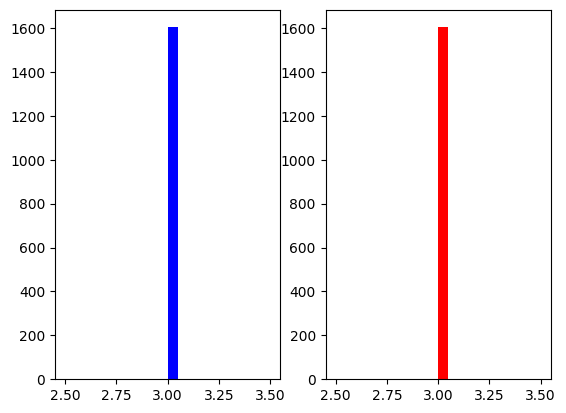

In [52]:
num_nodes_lst = []
num_edges_lst = []
for data in dataset:
    num_nodes = data.x.size()[0]
    num_edges = (data.edge_attr.size()[0])/2
    num_nodes_lst.append(num_nodes)
    num_edges_lst.append(num_edges)
fig, axs = plt.subplots(1,2)
axs[0].hist(num_nodes_lst, bins = 20, color = 'blue')
axs[1].hist(num_edges_lst, bins = 20, color = 'red')
plt.show()

# Train-Test Splits

In [53]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.75, 0.25
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [54]:
len(train_loader)

18

# Graph Visualization

In [55]:
def visualize_graph(data, *, save_fig=False, save_fig_path=None) -> None:
    """
    Visualize a graph with node features, labels, and edge attributes.
    
    Parameters:
    -----------
    data : Data
        PyTorch Geometric Data object with:
        - x: Node features [η, φ, pT, E]
        - node_label: Node type labels
        - edge_attr: Edge distances (ΔR)
        - eventno: Event number
        - y: Signal (1) vs background (0)
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])
    
    # Create labels and feature strings
    node_labels = {i: f'{label.item()}' for i, label in enumerate(data.node_label)}
    node_features = {
        i: (data.x[i][0].item(),   # η
            data.x[i][1].item(),   # φ
            data.x[i][2].item(),   # btag
            data.x[i][3].item())   # nodeLable
        for i in range(data.num_nodes)
    }

    plt.figure(figsize=(5, 3))
    pos = nx.spring_layout(G, seed=42, k=0.15)

    # Draw base graph
    nx.draw(G, pos, with_labels=True, node_size=500,
            node_color='skyblue', font_size=10, 
            font_weight='bold', edge_color='gray', 
            labels=node_labels)

    # Add node feature annotations
    for node, (eta, phi, bLabel, nodeLabel) in node_features.items():
        x, y = pos[node]
        feature_str = (f"η: {eta:.2f}\n"
                       f"φ: {phi:.2f}\n"
                       f"bTag: {bLabel:.1f}\n"
                       f"nodeLabel: {nodeLabel:.1f}")
        plt.text(x+0.12, y-0.12, feature_str, 
                 ha='center', va='top', 
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'),
                 fontsize=8, fontfamily='monospace')

    # Add edge distances
    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    edge_labels = {key: round(edge_labels[key][0], 2) for key in edge_labels}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=8)

    # Custom title
    event_type = "Signal" if data.y.item() == 1 else "Background"
    plt.title(f"{event_type} Event No.{data.eventno.item()}", fontsize=12)

    if save_fig and save_fig_path:
        plt.savefig(save_fig_path, bbox_inches='tight', pad_inches=0.1, dpi = 300)
        print(f"Figure saved to {save_fig_path}")

    plt.show()
    return None

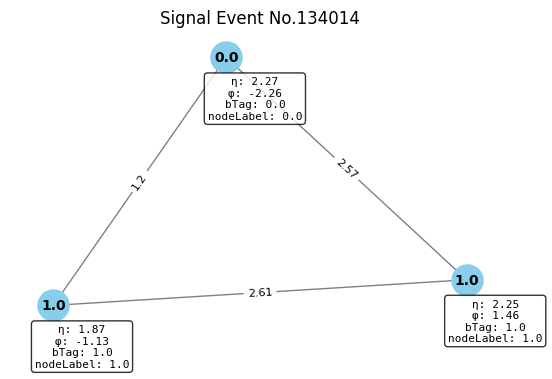

In [56]:
# from helper_function_module import visualize_graph
visualize_graph(dataset[idx], save_fig = False, save_fig_path = 'eventGraph.png')

## Model 4 Best

In [57]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features, *, num_hidden_graph_features=0):
        """
        GCN architecture for graph classification with learnable global pooling.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        if num_hidden_graph_features != 0:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_hidden_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )
            
            self.graph_features_nn = torch.nn.Sequential(
                torch.nn.Linear(num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, num_hidden_graph_features)
            )
        else:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )

        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(128, hidden_dim * hidden_dim)
        )
        
        self.conv1 = NNConv(hidden_dim, hidden_dim, nn=self.edge_nn, aggr='max')
        
        self.global_mean_pool_hook = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        x = F.relu(self.lin0(x))
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        
        # Use learnable global attention pooling
        x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)
        
        # Concatenate additional graph-level features
        graph_features = torch.cat([data.inv_mass.view(-1, 1), data.isophoton_pT.view(-1, 1)], dim=1)
        x = torch.cat([x, graph_features], dim=1)
        self.graph_embedding = x
        
        # Fully connected classification layers
        x = self.classify(x)
        return torch.sigmoid(x)

## Network Training

In [59]:
from helper_function_module import train, test
model = GCNClassifier(num_node_features=4,
                      num_edge_features = 1,
                      hidden_dim=10,
                      num_graph_features=2,
                      num_hidden_graph_features = 0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad = False)
criterion = torch.nn.BCELoss().to(device)

EPOCHS = 250
training_loss = []
test_accuracy = []
torch.cuda.empty_cache()

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader, device, optimizer, criterion)
        acc = test(model, test_loader, device, optimizer, criterion)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s, Loss=0.3291, Accuracy=0.8554]


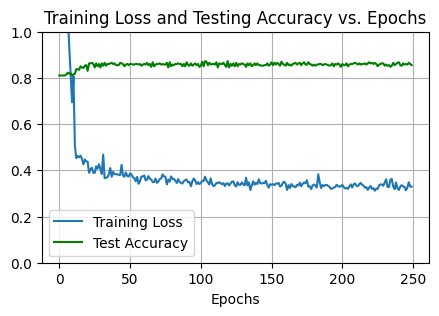

In [60]:
plt.figure(figsize = (5,3))
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.title('Training Loss and Testing Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.grid(which = 'both')
# plt.savefig('GCNConvTrainingLoss_TestAccuracy.png', dpi=300)
plt.show()

# Testing the Model Performance on Test Data

In [61]:
from helper_function_module import eval_model, get_labels_from_model
y_test_true, y_test_pred_prob, y_test_pred_labels = get_labels_from_model(model, test_dataset)

Counter({0.0: 325, 1.0: 76})


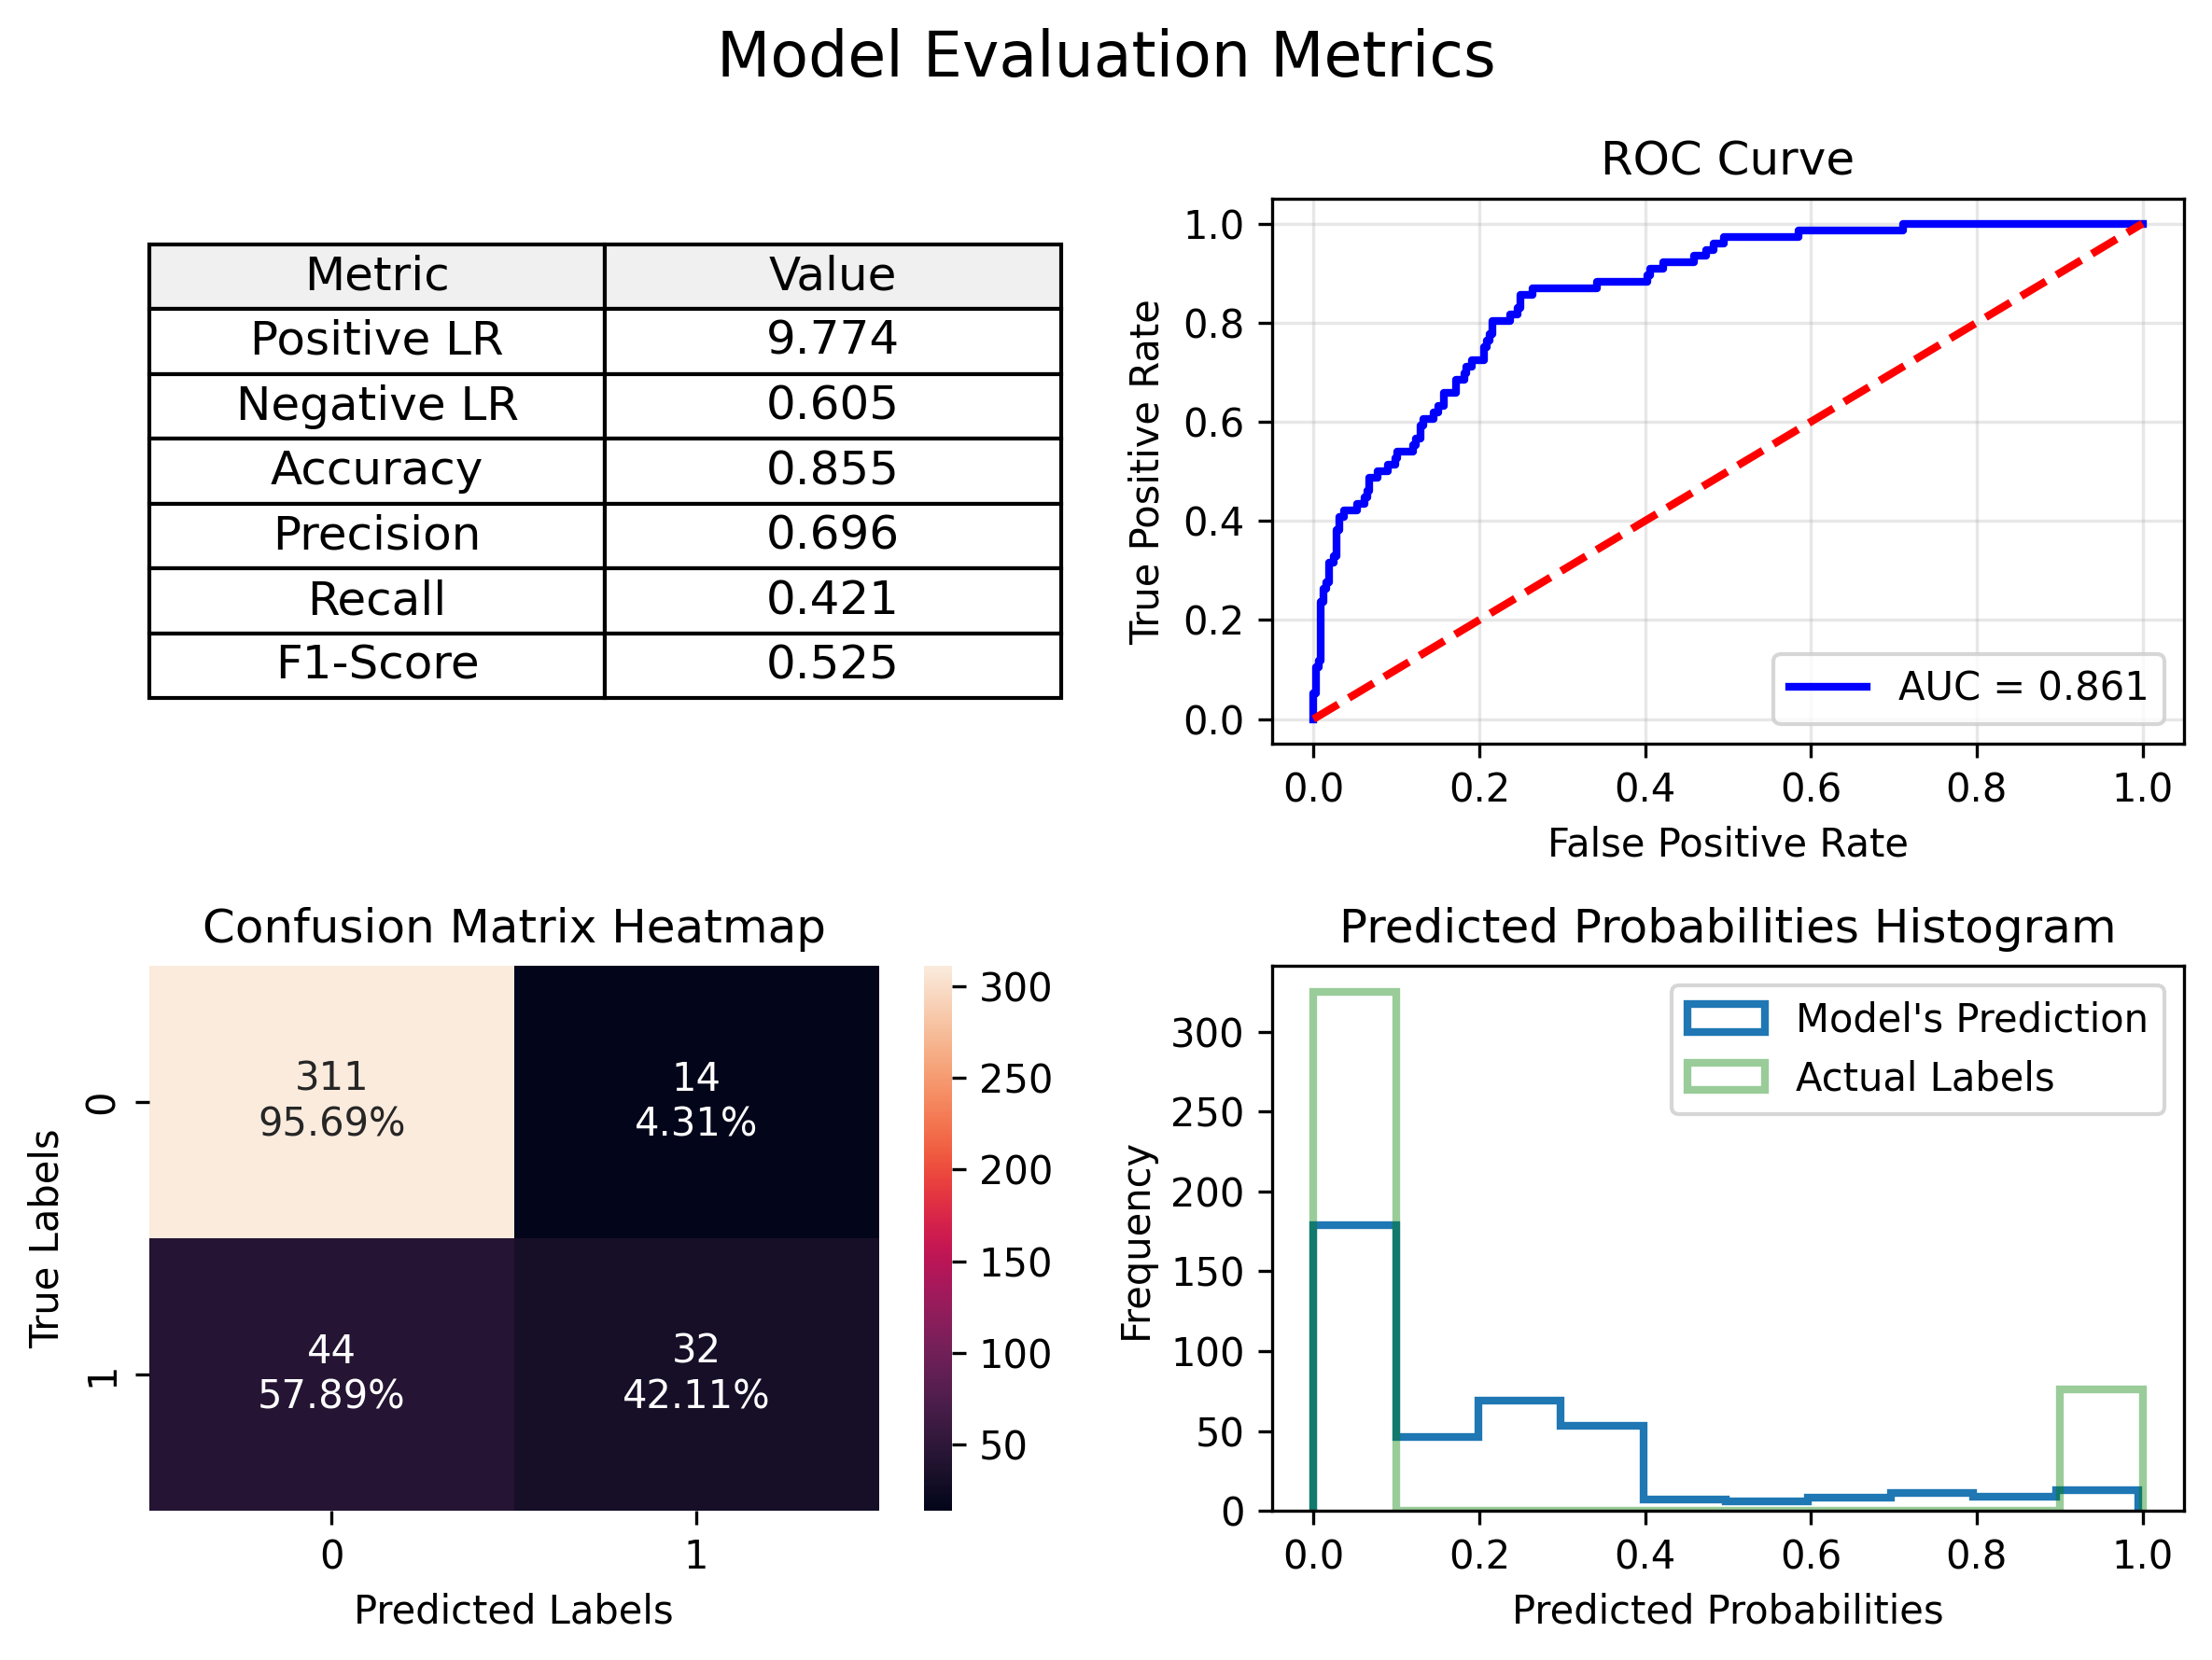

In [62]:
from collections import Counter
print(Counter(y_test_true))
eval_model(y_test_true, y_test_pred_prob, y_test_pred_labels, save_fig = False, save_fig_path = 'GCNConvMetricPlot.png')

# Lets check the distribution of edges formed for Signal and Background

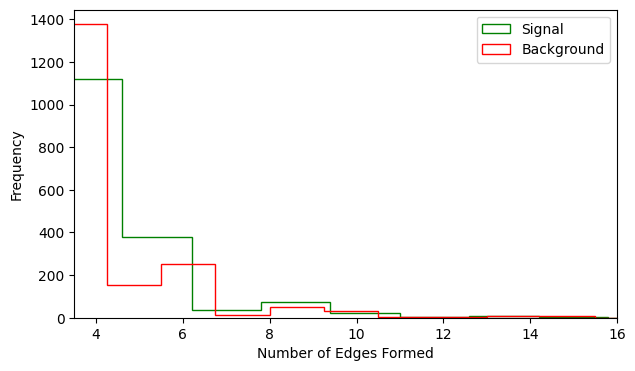

In [42]:
signal_num_edges = []
background_num_edges = []

for graph in dataset:
    if graph.y == 1:
        signal_num_edges.append((graph.edge_index.shape[1])/2)
    else:
        background_num_edges.append((graph.edge_index.shape[1])/2)
plt.figure(figsize = (7,4))
plt.hist(signal_num_edges, bins = 20, histtype = 'step', color = 'green', label = 'Signal')
plt.hist(background_num_edges, bins = 20, histtype = 'step', color = 'red', label = 'Background')
plt.xlabel('Number of Edges Formed')
plt.ylabel('Frequency')
plt.xlim([3.5, 16])
plt.legend()
plt.show()

In [70]:
# np.save('./model_output_arrays/GCNConv/GCConv_hd5_EtaPhiPtEBtaglabel', np.vstack((y_test_true, y_test_pred_prob)))

In [72]:
# # Reset the model Parameters
# def weight_reset(m):
#     if isinstance(m, torch_geometric.nn.GCNConv) or isinstance(m, torch.nn.Linear):
#         m.reset_parameters()

# model.apply(weight_reset)

# Evaluation Metrics for the Full dataset(train+test)

In [128]:
y_true, y_pred_prob, y_pred_labels = get_labels_from_model(model, dataset)

Counter({0.0: 1897, 1.0: 1649})


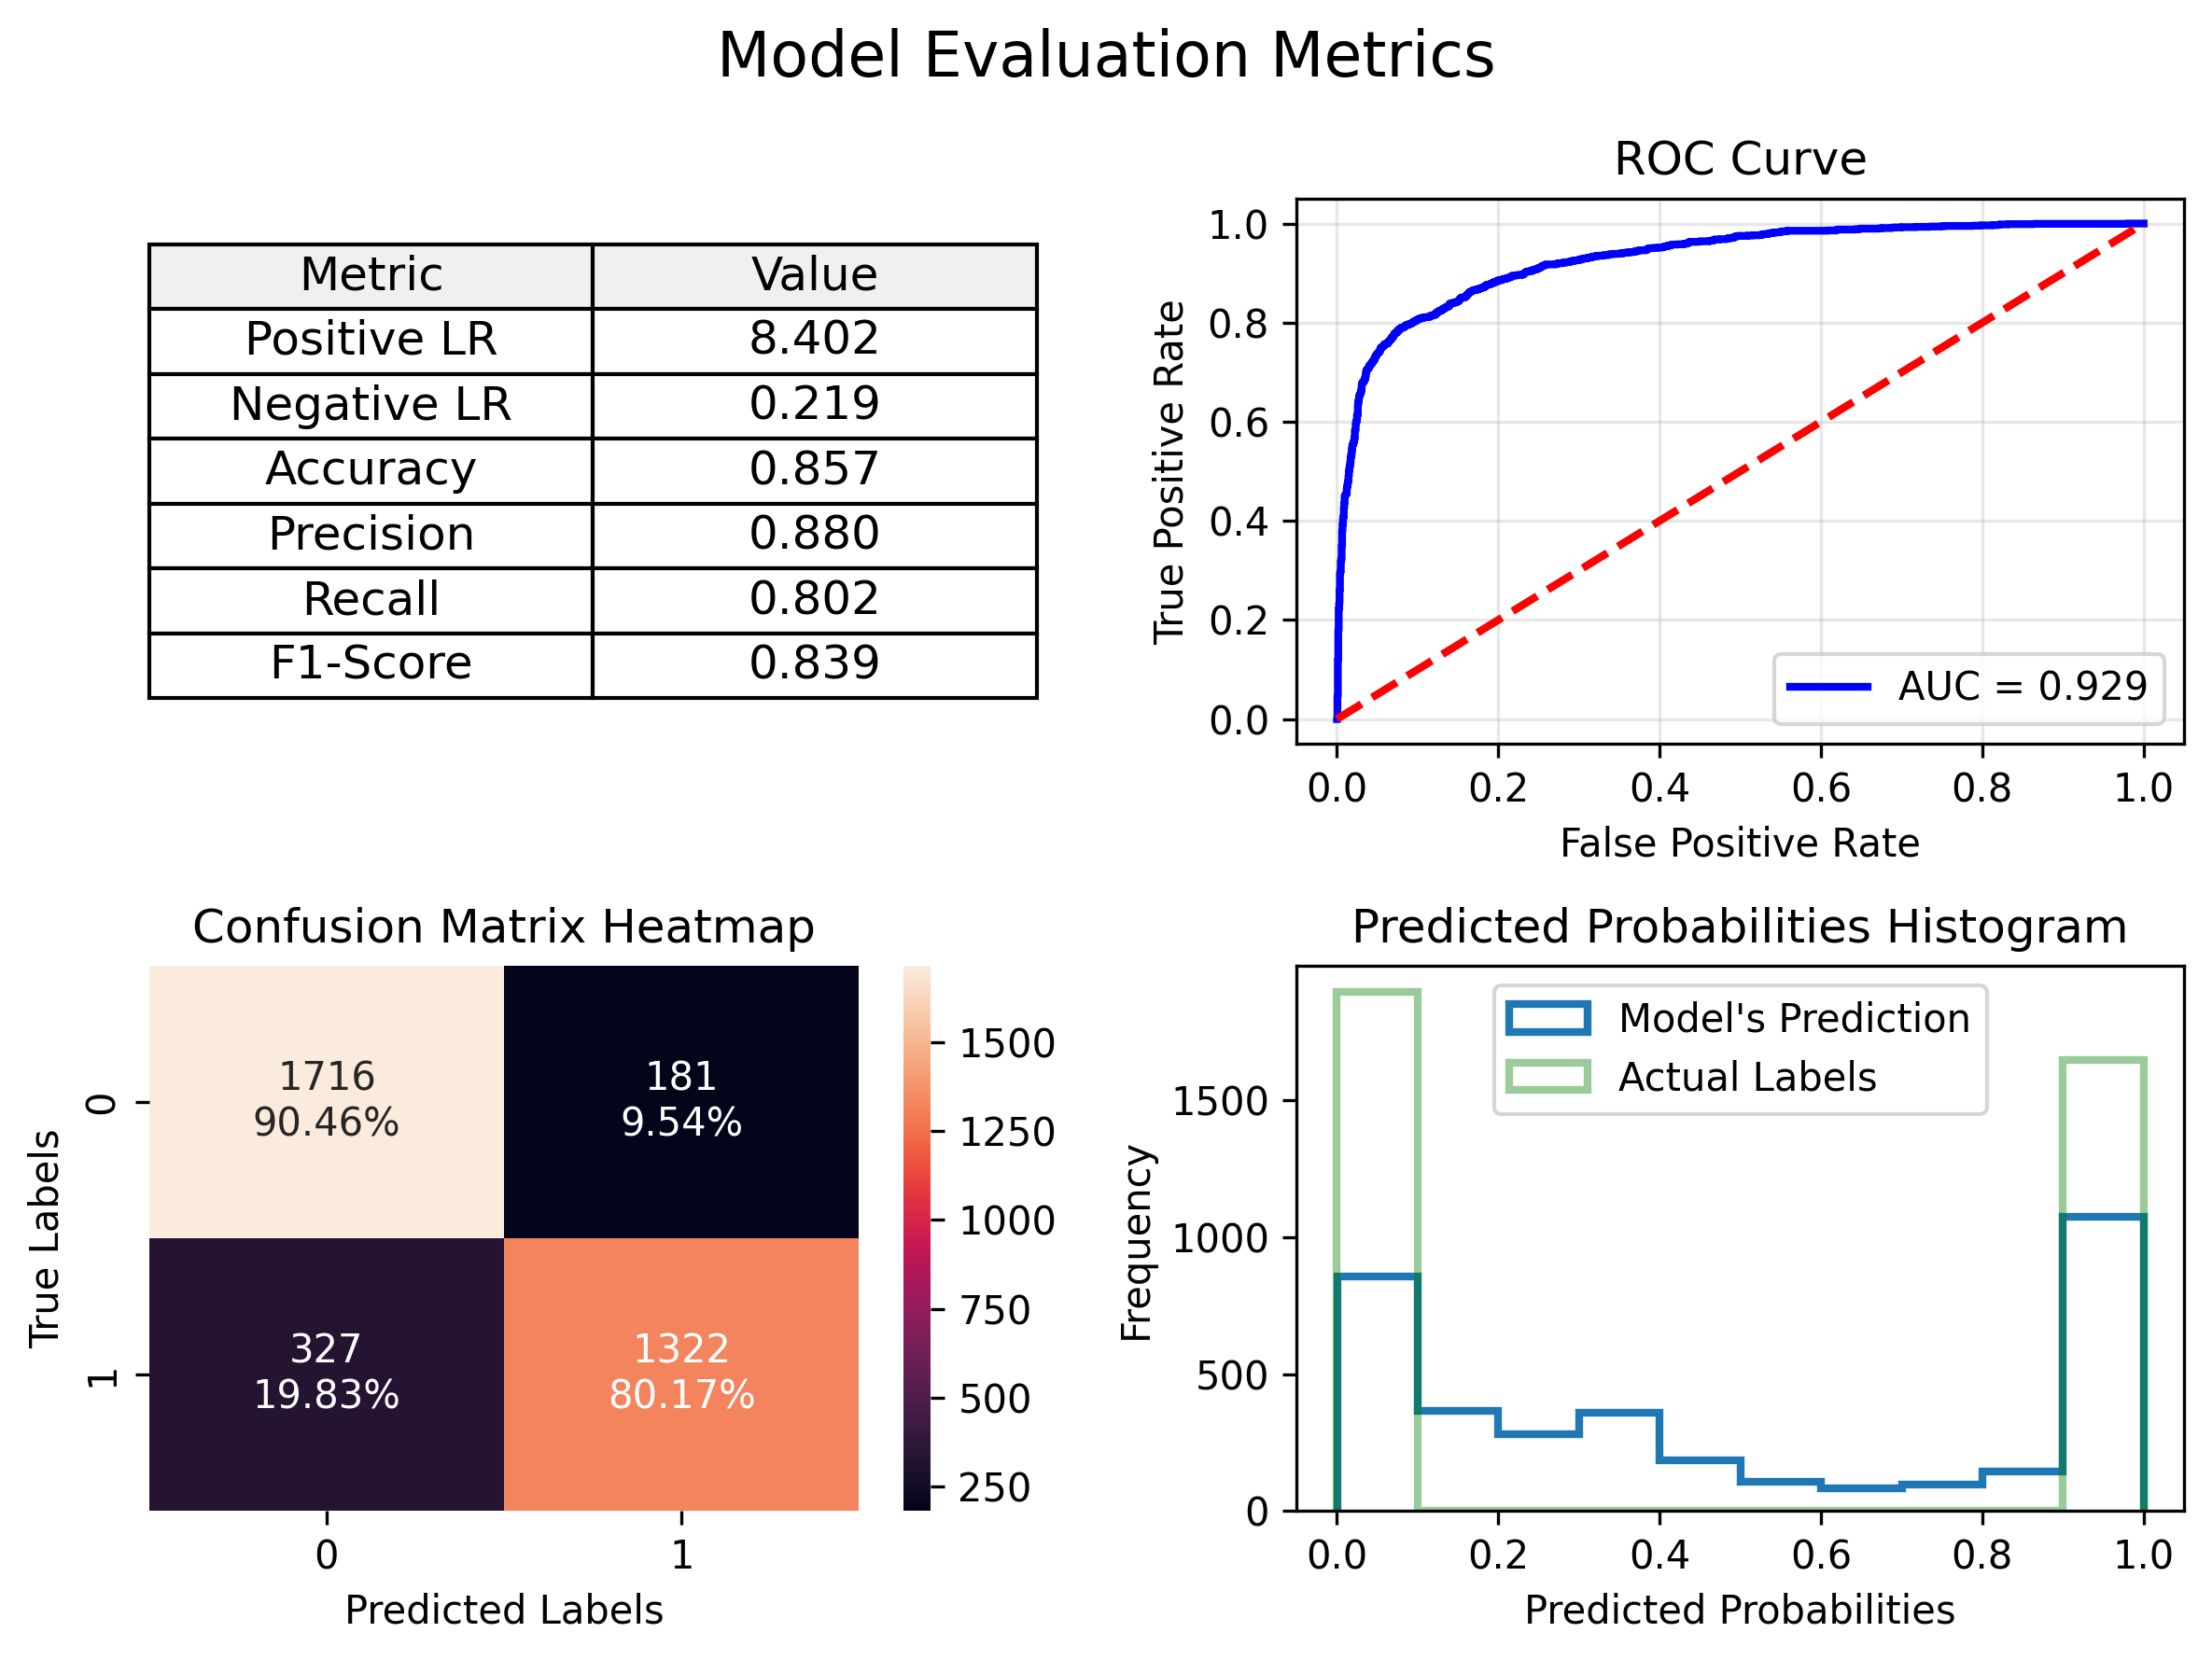

In [129]:
from collections import Counter
print(Counter(y_true))
eval_model(y_true, y_pred_prob, y_pred_labels, save_fig = False, save_fig_path = 'GCNConvMetricPlot.png')

In [130]:
# np.save('NNConv_main_model', np.vstack((y_true, y_pred_prob)))
# torch.save(model, 'NNConv_main_model.pth')

# Extracting Graph Embedding from the Model

In [131]:
from helper_function_module import get_graph_embeddings
embedding_df = get_graph_embeddings(model, dataset)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Classifying the Graph Embeddings Using a Random Forest Model from these graph embeddings

In [132]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [133]:
X, y = embedding_df.iloc[:,:-2].values, embedding_df.iloc[:,-2].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [134]:
param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=seed),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Best Model Test Accuracy: 0.82
Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200}
ROC AUC: 0.90


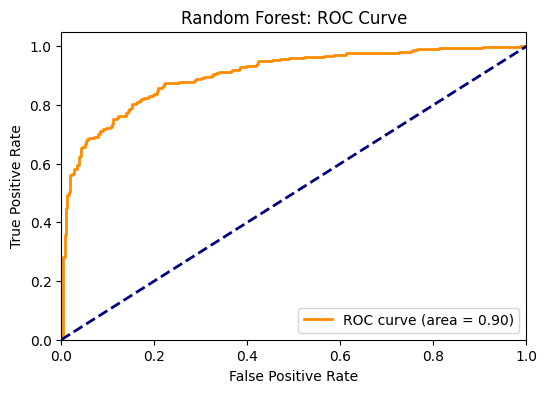

In [135]:
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Test Accuracy: {accuracy:.2f}')
print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: ROC Curve')
plt.legend(loc="lower right")
plt.show()

## ANN Based Classifier

In [136]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

2025-03-18 04:17:08.094611: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 04:17:09.276430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 04:17:09.276581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 04:17:09.479395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 04:17:09.848581: I tensorflow/core/platform/cpu_feature_guar

In [137]:
input_size = X.shape[1]
model_ANN = Sequential([
    Input((input_size,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Train the model
history = model_ANN.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/40
36/36 [==============================] - 2s 16ms/step - loss: 0.6444 - accuracy: 0.6914 - precision: 0.6797 - recall: 0.6183 - auc: 0.7460 - val_loss: 0.4465 - val_accuracy: 0.8187 - val_precision: 0.8065 - val_recall: 0.8212 - val_auc: 0.8946
Epoch 2/40
36/36 [==============================] - 0s 4ms/step - loss: 0.4721 - accuracy: 0.8025 - precision: 0.7857 - recall: 0.7827 - auc: 0.8647 - val_loss: 0.4208 - val_accuracy: 0.8275 - val_precision: 0.8465 - val_recall: 0.7847 - val_auc: 0.9033
Epoch 3/40
36/36 [==============================] - 0s 5ms/step - loss: 0.4435 - accuracy: 0.8038 - precision: 0.8020 - recall: 0.7596 - auc: 0.8772 - val_loss: 0.4087 - val_accuracy: 0.8398 - val_precision: 0.8560 - val_recall: 0.8029 - val_auc: 0.9045
Epoch 4/40
36/36 [==============================] - 0s 5ms/step - loss: 0.4064 - accuracy: 0.8294 - precision: 0.8349 - recall: 0.7827 - auc: 0.8972 - val_loss: 0.4035 - val_accuracy: 0.8310 - val_precision: 0.8397 - val_recall: 0.8029 -

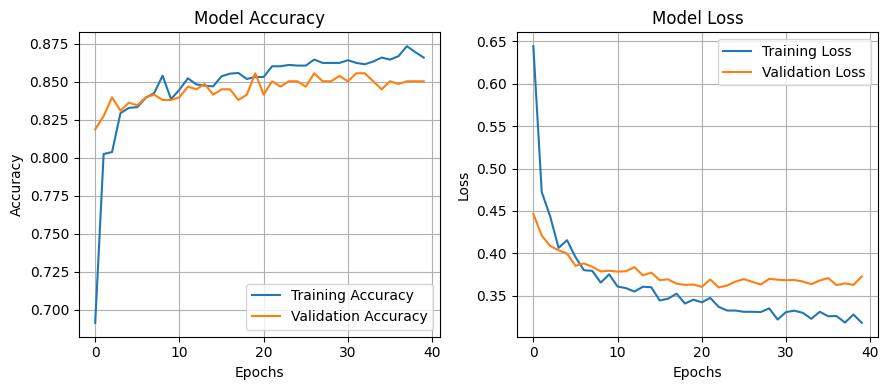

23/23 [==============================] - 0s 2ms/step - loss: 0.3920 - accuracy: 0.8254 - precision: 0.8392 - recall: 0.7791 - auc: 0.9064
Test Loss: 0.3920, Test Accuracy: 0.8254, Precision: 0.8392, Recall: 0.7791, AUC: 0.9064
23/23 [==============================] - 0s 2ms/step
Example probabilities: [[0.30082586]
 [0.05550346]
 [0.04868574]
 [0.94797707]
 [0.01766446]]
Precision: 0.8392, Recall: 0.7791, F1 Score: 0.8080, ROC AUC: 0.9061


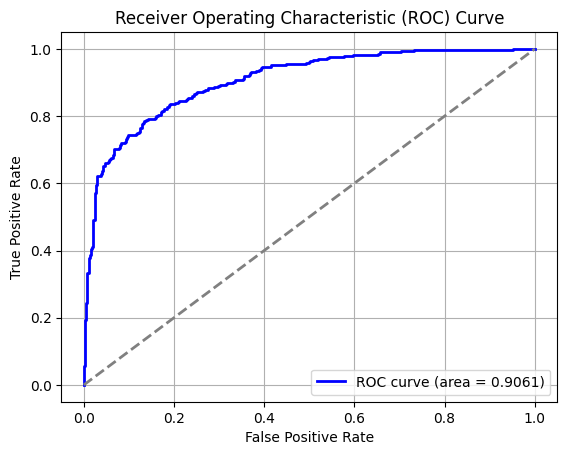

In [138]:
# Plotting training history
plt.figure(figsize=(9, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
evaluation_results = model_ANN.evaluate(X_test, y_test)
loss, accuracy, precision, recall, auc = evaluation_results
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Predict probabilities for the test set
probability_scores = model_ANN.predict(X_test)
print("Example probabilities:", probability_scores[:5])

# Additional evaluation metrics
predictions = (probability_scores > 0.5).astype(int)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probability_scores)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probability_scores)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()